In [1]:
#!pip install theano
#!pip install keras
#!pip install tensorflow

In [2]:
import os, sys
import pickle
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils
from week6.abi.solution_scripts import data_wrangling
from week6.abi.solution_scripts.Networks import (LSTM, Facebook, ANN, VAR)
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import LabelEncoder



In [3]:

#%matplotlib inline
register_matplotlib_converters()
%load_ext autoreload
%autoreload 2

In [4]:
# extract clean data and uncomment below
#main_data = pd.read_csv('clean_data.csv',index_col='Time')

In [5]:
main_data = main_data.replace([np.inf, -np.inf], np.nan)
main_data[main_data.isna().any(axis=1)]

,Reporter,Commodity Code,Trade Value (US$),Category Code,Gdp_per_capita,Population
Time,,,,,,


In [6]:
main_data.index = pd.to_datetime(main_data.index, format="%Y-%m-%d").to_period('M')

In [7]:
output_column = 'Trade Value (US$)'

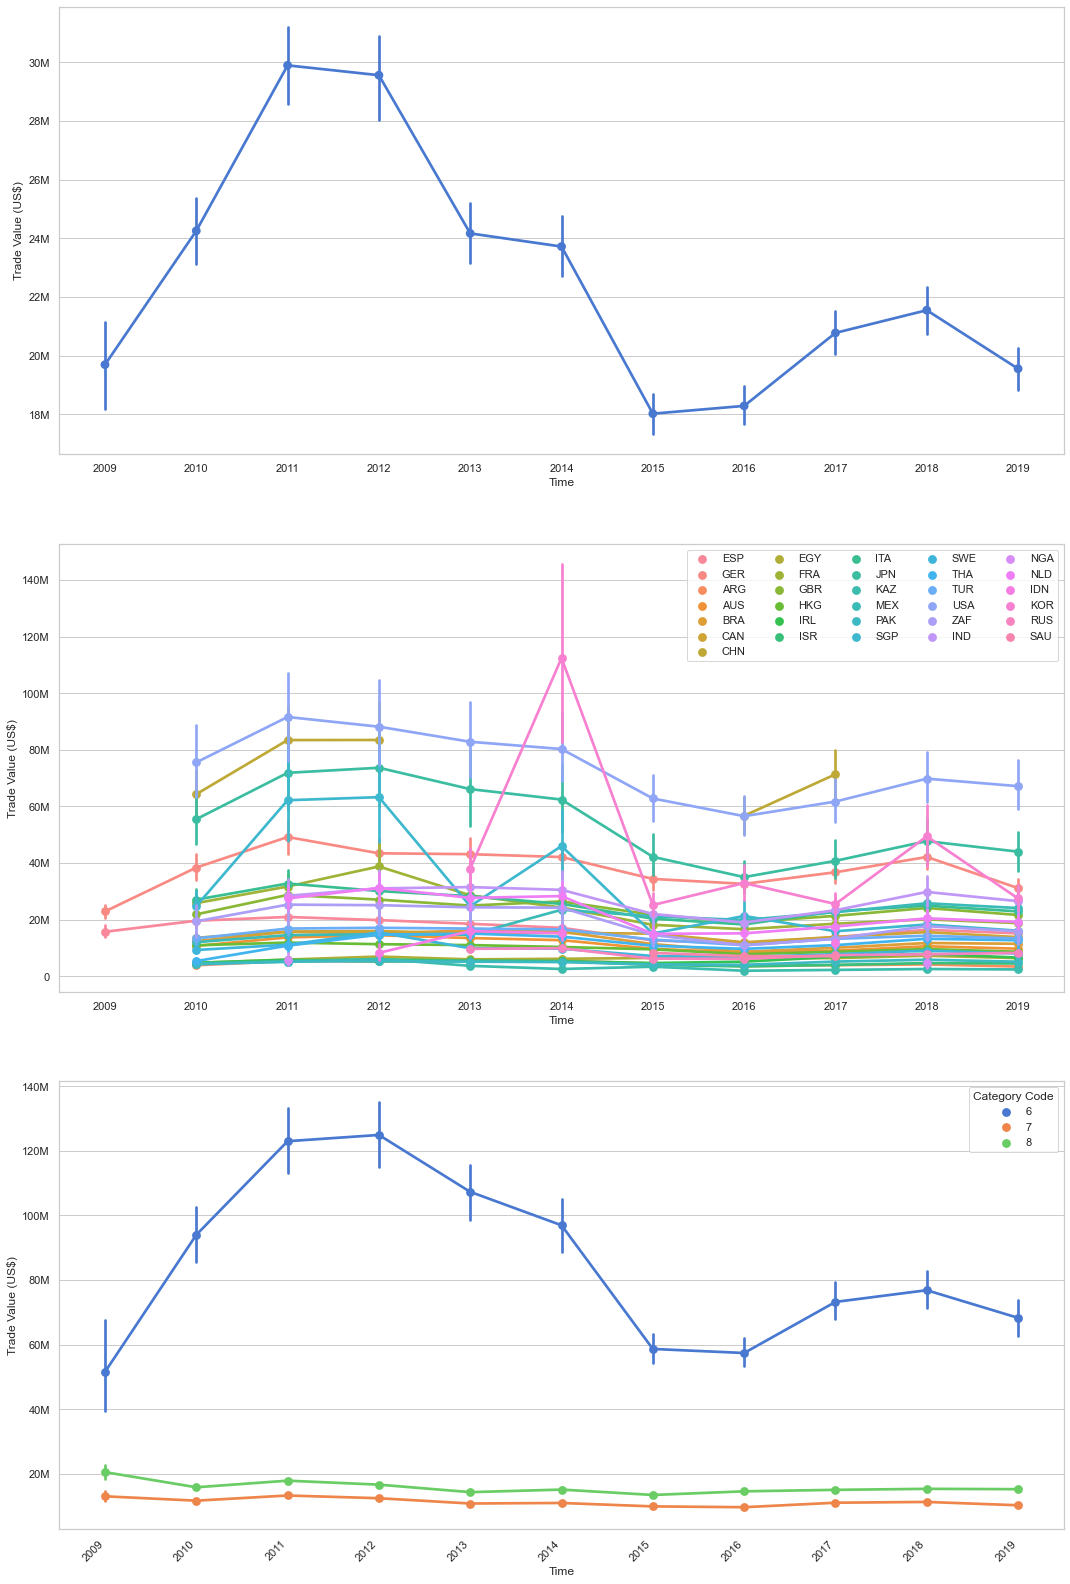

In [8]:

sns.set(style='whitegrid', palette='muted')
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18, 28)
plt.xticks(rotation=45, horizontalalignment='right')
data = main_data.copy()
#data.index = pd.DatetimeIndex(data.index).year
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g = sns.pointplot(x=data.index.year, y=output_column, data=data, ax=ax1);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));

g = sns.pointplot(x=data.index.year, y=output_column, data=data, hue="Reporter", ax=ax2);
handles = g.legend_.legendHandles
labels = g.legend_.get_label()
g.legend(handles=handles, labels=labels, loc='upper right', ncol=5)
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g = sns.pointplot(x=data.index.year, y=output_column, data=data, hue="Category Code", ax=ax3);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));





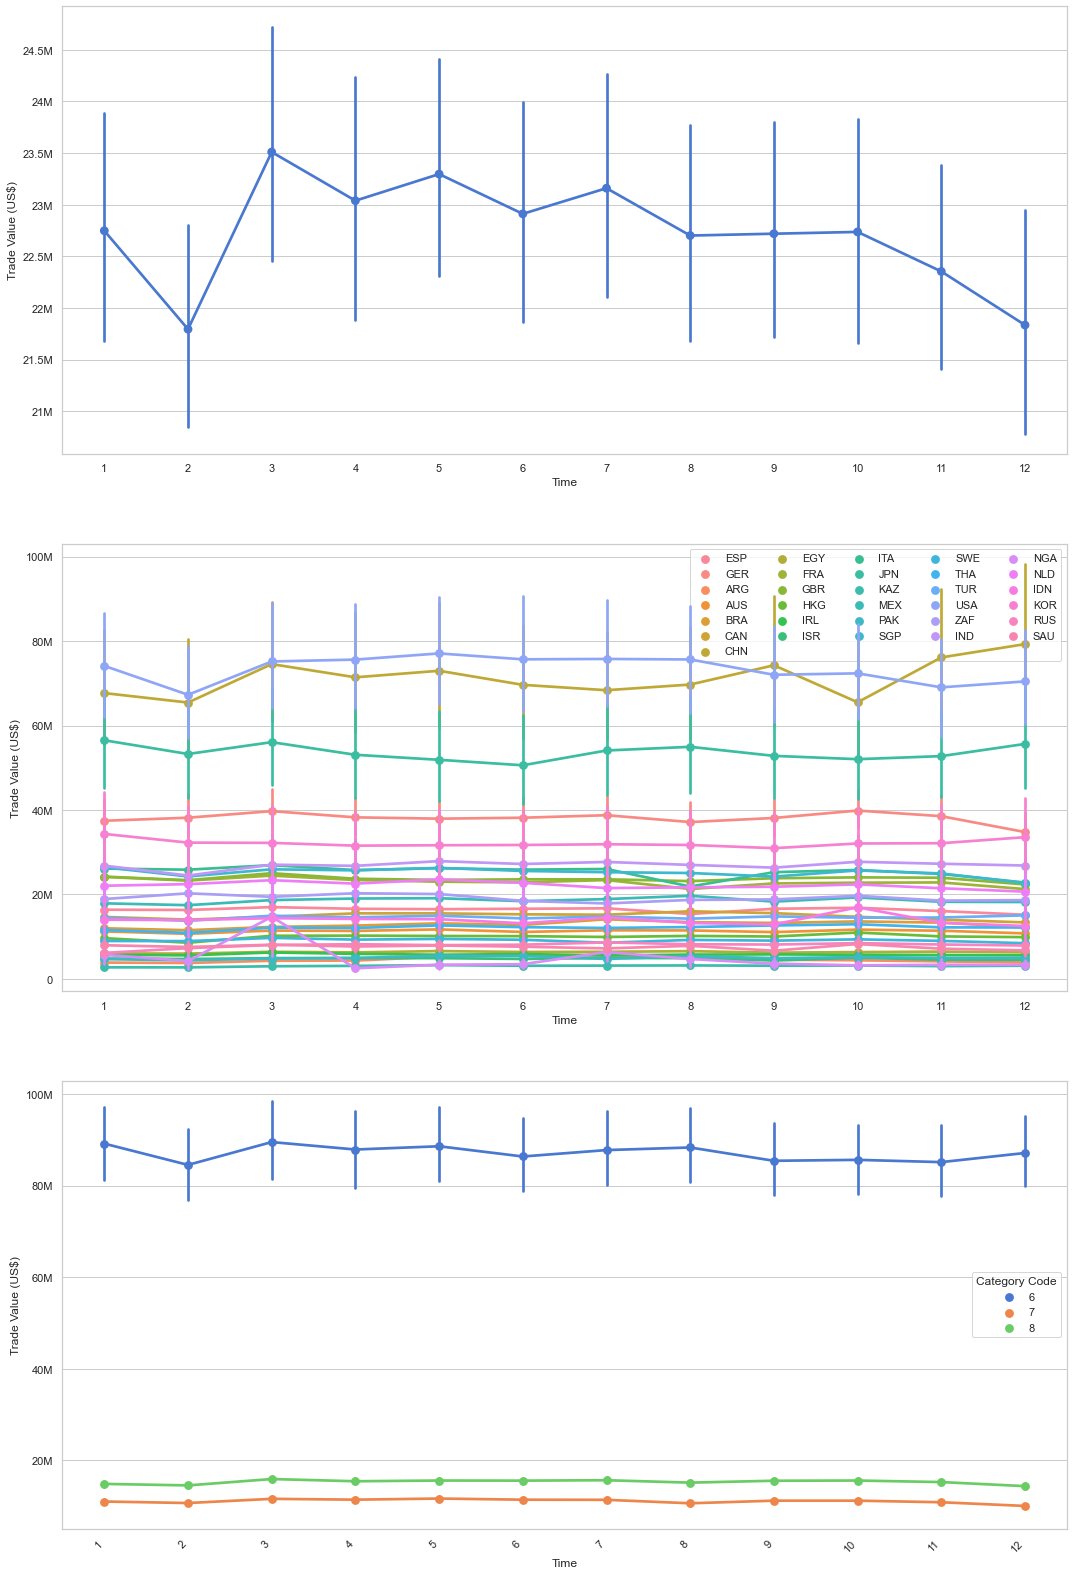

In [9]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18, 28)
plt.xticks(rotation=45, horizontalalignment='right')
data = main_data.copy()
#data.index = pd.DatetimeIndex(data.index).year
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g = sns.pointplot(x=data.index.month, y=output_column, data=data, ax=ax1);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));

g = sns.pointplot(x=data.index.month, y=output_column, data=data, hue="Reporter", ax=ax2);
handles = g.legend_.legendHandles
labels = g.legend_.get_label()
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.legend(handles=handles, labels=labels, loc='upper right', ncol=5)

g=sns.pointplot(x=data.index.month, y=output_column, data=data, hue="Category Code", ax=ax3);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));

In [3]:
sns.set_theme()

# Summary of models
## FB Prophet
* FB Prophet gives the best accuracy from the models tested so far
* This model is typically used for univariant time series data
* We removed columns all categorical values (Commodity, Reporter). The train dataset is monthly average trade value for each product category till 2018. The test dataset is the monthly average trade value for each category in the year 2019
* FB prophet performs quite well and is also able to predict the trends. The average loss is 1509.086318
## VAR
* Vector Auto regression (VAR) is a statistical auto regression model that is typically used for multi-variant time series data
* To prepare the data, we removed the Commodity column. We then averaged the trade value of each product categoryper Reporter and their population data. 
* The train data set is the per reporter monthly average trade value for each product category and the population data till 2018. The test dataset is the per reporter monthly average trade value for each category in the year 2019 and population.
* We then group the train data into commodity categories, drop the reporter column, because VAR doesn't accept categorical data. The model is trained for each product category
* Compared to the FB prophet, VAR doesn't perform as good. It is unable to seemingly detect trends and monthly spikes in the data for each product category. It average loss is 30775720 which is higher than that of fb phrophet
## ANN
* Our artificial nneural network is a multilayer perceptron
* Due to the mixed nature of our data set (numerical and categorical), we need a model that performs both classification and regression. To achieve this, hidden layers are used for classification, then the final layer is the regression layer (linear). ReLu activation is used between layers
* Preprocessing: A Robust scaler is used to scale the numerical input features (Trade Value, GDP per capita, Population) and, while the categorical columns (Reporter, Product Category) are one-hot encoded as binary value of each label. Addtionally, the monthly trade value for each reporter per commodity is also averaged
* Robust Scaler is used to scale features using statistics that are robust to outliers. It removes the median and scales the data according to IQR (IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method
* Architecture: After rigorous training and tests using different models, a Multilayer perceptron with three hidden layers was selected. The first layer (input layer), has 512 neurons, second layer, 256, third layer 128, fourth layer 64, and finally a linear output layer. Relu gave the best result and was selected as the optimal activation function for our model. A drop out layer and batch normalization were also added in between the layers, for regularization. He Initialization was used for initializing the weights of each layer

* Training: 25% of the train data is used for validation. Our model is initialized with the Adam optimizer. We’re using mean absolute error as our loss function, indicating that we seek to minimize the mean difference between the predicted trade value and the actual trade value. 

* Overall the best mean absolute percentage that we were able to obtain with our neural network, after rigorous training and hyper paramter tuning was a mean absolute error of 638.05%, implying that, on average, our trade value predictions will be off by 638.05%, with a standard deviation of 9077.56%. This is a very bad result, and on a average, it shows that a simple ANN is simply not able to determine the trends in our dataset. 


In [104]:
from heatmap import heatmap, corrplot

In [97]:
corr_data = main_data.groupby([main_data.index, 'Reporter','Category Code']).agg({output_column:'sum', 'Gdp_per_capita':'last', 'Population':'last'})

In [148]:
def show_corr(df, metric_1, metric_2, metric_3):
    df_1 = df.groupby(['Time', 'Reporter']).agg({metric_1:"sum"})
    Reporter = df_1.groupby(['Reporter']).agg({metric_1:"sum"})
    df_1 = df_1.div(Reporter, level='Reporter') * 100

    df_2 = df.groupby(['Time', 'Reporter']).agg({metric_2:"sum"})
    Reporter = df_2.groupby(['Reporter']).agg({metric_2:"sum"})
    df_2 = df_2.div(Reporter, level='Reporter') * 100
   
    data_Frame = pd.concat([df_1,df_2], axis=1, join='inner')
    df_3 = df.groupby(['Time', 'Reporter']).agg({metric_3:"sum"})
    Reporter = df_3.groupby(['Reporter']).agg({metric_3:"sum"})
    df_3 = df_3.div(Reporter, level='Reporter') * 100
    data_Frame = pd.concat([data_Frame,df_3], axis=1, join='inner').reset_index()
    #data_Frame = data_Frame.melt(id_vars=['Time','Reporter'], value_vars=[metric_1, metric_2, metric_3], var_name="Metric", ignore_index=False)
    corr = data_Frame.corr()
    data_Frame = data_Frame.groupby(["Reporter"]).corr().reset_index().replace(np.nan, 0)
    #print(data_Frame.tail(50))
    curr = data_Frame[~(data_Frame['level_1']==metric_1)]
    plt.figure(figsize=(11, 3))
    heatmap(y=curr["level_1"], x=curr["Reporter"], size=curr[metric_1],  marker='o', palette=sns.cubehelix_palette(start=2.8, rot=.1), color=curr[metric_1], xlabel="Reporter", ylabel="Metric")
    metric_1 = metric_1.replace('_', ' ')
    metric_2 = metric_2.replace('_', ' ')
    plt.suptitle(f"Correlation of {metric_1} and {metric_2}")
    return corr
    
    


In [161]:
def show_corr_avg(df, metric_1, metric_2, metric_3):
    
    data_Frame = df.groupby(['Time', 'Reporter']).agg({metric_1:"mean", metric_2:"last", metric_3:"last"})
    
    #data_Frame = data_Frame.melt(id_vars=['Time','Reporter'], value_vars=[metric_1, metric_2, metric_3], var_name="Metric", ignore_index=False)
    corr = data_Frame.corr()
    data_Frame = data_Frame.groupby(["Reporter"]).corr().reset_index().replace(np.nan, 0)
    #print(data_Frame.tail(50))
    curr = data_Frame[~(data_Frame['level_1']==metric_1)]
    plt.figure(figsize=(11, 3))
    heatmap(y=curr["level_1"], x=curr["Reporter"], size=curr[metric_1],  marker='o', palette=sns.cubehelix_palette(start=2.8, rot=.1), color=curr[metric_1], xlabel="Reporter", ylabel="Metric")
    metric_1 = metric_1.replace('_', ' ')
    metric_2 = metric_2.replace('_', ' ')
    plt.suptitle(f"Correlation of avg. Import Trade Value and metrics")
    return corr
    
    

#log gdp and trade val

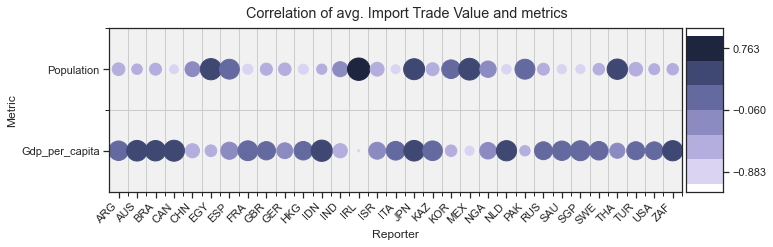

In [162]:
corr_avg = show_corr_avg(corr_data, output_column, 'Gdp_per_capita', 'Population' )

In [157]:
corr_avg

,Trade Value (US$),Gdp_per_capita,Population
Trade Value (US$),1.000000,0.206025,0.430819
Gdp_per_capita,0.206025,1.000000,-0.231851
Population,0.430819,-0.231851,1.000000


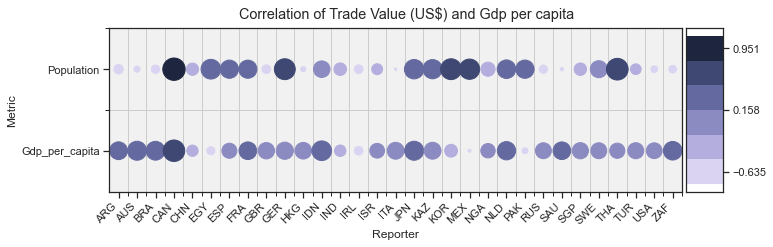

In [149]:
corr = show_corr(corr_data, output_column, 'Gdp_per_capita', 'Population' )


In [160]:
from tabulate import tabulate as tb
headers = ['Trade Value (US$)',	'Gdp_per_capita','Population']
with open("Corr_results.txt", "a") as text_file:
    print(f'{tb(corr_avg, showindex=True, tablefmt="mediawiki", headers=headers)}', file=text_file)


In [159]:
corr_avg

,Trade Value (US$),Gdp_per_capita,Population
Trade Value (US$),1.000000,0.206025,0.430819
Gdp_per_capita,0.206025,1.000000,-0.231851
Population,0.430819,-0.231851,1.000000


## Train with ANN

In regression model, the most commonly known evaluation metrics include:

R-squared (R2), which is the proportion of variation in the outcome that is explained by the predictor variables. In multiple regression models, R2 corresponds to the squared correlation between the observed outcome values and the predicted values by the model. The Higher the R-squared, the better the model.

Root Mean Squared Error (RMSE), which measures the average error performed by the model in predicting the outcome for an observation. Mathematically, the RMSE is the square root of the mean squared error (MSE), which is the average squared difference between the observed actual outome values and the values predicted by the model. So, MSE = mean((observeds - predicteds)^2) and RMSE = sqrt(MSE). The lower the RMSE, the better the model.

Residual Standard Error (RSE), also known as the model sigma, is a variant of the RMSE adjusted for the number of predictors in the model. The lower the RSE, the better the model. In practice, the difference between RMSE and RSE is very small, particularly for large multivariate data.

Mean Absolute Error (MAE), like the RMSE, the MAE measures the prediction error. Mathematically, it is the average absolute difference between observed and predicted outcomes, MAE = mean(abs(observeds - predicteds)). MAE is less sensitive to outliers compared to RMSE.


In [16]:
from sklearn.model_selection import train_test_split
data = main_data.groupby(['Time','Reporter', 'Category Code']).agg({output_column:'mean', 'Population':'last', 'Gdp_per_capita':'last'}).reset_index().set_index('Time')
data = pd.get_dummies(data, columns=['Reporter', 'Category Code'])
train_raw = data[data.index<"2019"]
test_raw = data[data.index>="2019"]
train_raw, val_raw = train_test_split(train_raw, test_size=0.2, random_state=42)

In [17]:
ann = ANN(df=data.copy(), output_column=output_column, continuous_cols=['Gdp_per_capita', 'Population'], train_raw=train_raw, val_raw = val_raw, test_raw=test_raw)
trainx, trainY,  valx, valY= ann.prepare()
ann.create_model(512)

In [18]:
size_histories = {}

In [19]:
def train(ann, size_histories, hparams, model_name, csv_filename, recreate_model=False, neurons=256):
  if recreate_model:
    ann.create_model(neurons)
  hist, model = ann.train_model(hparams, model_name, csv_filename)
  size_histories[model_name] = hist
  return model, size_histories


In [20]:
def plot_loss_acc(result, title1, title2, loss_pic_title, with_log):
    plt.plot(result['loss'])
    plt.plot(result['val_loss'])
    plt.title(title1)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if with_log:
        plt.yscale('log')
    plt.savefig(loss_pic_title);
    plt.show();
    

In [25]:
ann.train_trials(50)
#{'dropout_1': 0.26,
# 'dropout_2': 0.31000000000000005,
# 'dropout_3': 0.36000000000000004,
# 'lr': 0.0003309373119942461,
# 'decay': 0.0002653252665537072,
# 'batchsize': 108}

.8777
Epoch 7/15
15/15 - 0s - loss: 0.8638 - val_loss: 0.8777
Epoch 8/15
15/15 - 0s - loss: 0.8645 - val_loss: 0.8776
Epoch 9/15
15/15 - 0s - loss: 0.8640 - val_loss: 0.8777
Epoch 10/15
15/15 - 0s - loss: 0.8654 - val_loss: 0.8776
Epoch 11/15
15/15 - 0s - loss: 0.8651 - val_loss: 0.8776
Epoch 12/15
15/15 - 0s - loss: 0.8639 - val_loss: 0.8776
Epoch 13/15
15/15 - 0s - loss: 0.8637 - val_loss: 0.8776
Epoch 14/15
15/15 - 0s - loss: 0.8663 - val_loss: 0.8777
Epoch 15/15
15/15 - 0s - loss: 0.8658 - val_loss: 0.8776
[I 2021-01-27 15:31:07,285] Finished trial#31 with value: 0.8776401281356812 with parameters: {'lr': 1.1088113016126867e-05, 'decay': 0.002401969018217079, 'batchsize': 476}. Best is trial#24 with value: 0.877364993095398.
Epoch 1/15
16/16 - 1s - loss: 0.8660 - val_loss: 0.8777
Epoch 2/15
16/16 - 0s - loss: 0.8642 - val_loss: 0.8778
Epoch 3/15
16/16 - 0s - loss: 0.8651 - val_loss: 0.8777
Epoch 4/15
16/16 - 0s - loss: 0.8645 - val_loss: 0.8777
Epoch 5/15
16/16 - 0s - loss: 0.8644 

{'lr': 7.426740066288046e-05, 'decay': 7.278619571631004e-05, 'batchsize': 260}

In [21]:
hparams= {'batch':368, 'lr':0.0007921933842039855, 'decay_rate':1.6979193955274406e-05, 'epochs':500}
model, size_histories = train(ann, size_histories, hparams, 'large_model_relu_robust', 'history')

ot_mean_squared_error: 2.0115 - val_loss: 0.8814 - val_root_mean_squared_error: 2.0360
Epoch 334/500
19/19 - 0s - loss: 0.8701 - root_mean_squared_error: 2.0301 - val_loss: 0.8806 - val_root_mean_squared_error: 2.0371
Epoch 335/500
19/19 - 0s - loss: 0.8714 - root_mean_squared_error: 2.0246 - val_loss: 0.8811 - val_root_mean_squared_error: 2.0394
Epoch 336/500
19/19 - 0s - loss: 0.8700 - root_mean_squared_error: 2.0237 - val_loss: 0.8838 - val_root_mean_squared_error: 2.0339
Epoch 337/500
19/19 - 0s - loss: 0.8705 - root_mean_squared_error: 1.9970 - val_loss: 0.8812 - val_root_mean_squared_error: 2.0401
Epoch 338/500
19/19 - 0s - loss: 0.8691 - root_mean_squared_error: 2.0311 - val_loss: 0.8823 - val_root_mean_squared_error: 2.0377
Epoch 339/500
19/19 - 0s - loss: 0.8690 - root_mean_squared_error: 2.0251 - val_loss: 0.8836 - val_root_mean_squared_error: 2.0297
Epoch 340/500
19/19 - 0s - loss: 0.8703 - root_mean_squared_error: 2.0365 - val_loss: 0.8807 - val_root_mean_squared_error: 2.0

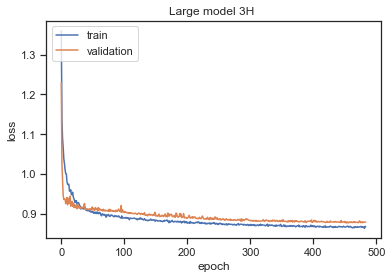

In [22]:

result = pd.DataFrame(size_histories['large_model_relu_robust'].history)

plot_loss_acc(result, 'Large model 3H ','Large model 3H rmse', 'large_model_relu_robust/large_model_relu_robust.png', False)

In [33]:
hparams= {'batch':260, 'lr':7.426740066288046e-05, 'decay_rate':7.278619571631004e-05, 'epochs':500}
model, size_histories = train(ann, size_histories, hparams, 'simple_model_relu_robust', 'history', True, 256)

_mean_squared_error: 2.0358 - val_loss: 0.9190 - val_root_mean_squared_error: 2.0365
Epoch 202/500
26/26 - 0s - loss: 0.9252 - root_mean_squared_error: 2.0278 - val_loss: 0.9190 - val_root_mean_squared_error: 2.0364
Epoch 203/500
26/26 - 0s - loss: 0.9326 - root_mean_squared_error: 2.0539 - val_loss: 0.9187 - val_root_mean_squared_error: 2.0371
Epoch 204/500
26/26 - 0s - loss: 0.9321 - root_mean_squared_error: 2.0499 - val_loss: 0.9186 - val_root_mean_squared_error: 2.0371
Epoch 205/500
26/26 - 0s - loss: 0.9296 - root_mean_squared_error: 2.0491 - val_loss: 0.9195 - val_root_mean_squared_error: 2.0363
Epoch 206/500
26/26 - 0s - loss: 0.9346 - root_mean_squared_error: 2.0554 - val_loss: 0.9191 - val_root_mean_squared_error: 2.0354
Epoch 207/500
26/26 - 0s - loss: 0.9292 - root_mean_squared_error: 2.0389 - val_loss: 0.9175 - val_root_mean_squared_error: 2.0384
Epoch 208/500
26/26 - 0s - loss: 0.9269 - root_mean_squared_error: 2.0343 - val_loss: 0.9196 - val_root_mean_squared_error: 2.036

In [92]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 256)               768       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
H2 (Dense)                   (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                

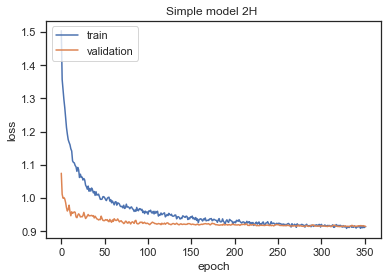

In [34]:
result = pd.DataFrame(size_histories['simple_model_relu_robust'].history)

plot_loss_acc(result, 'Simple model 2H ','Simple model 2H rmse', 'simple_model_relu_robust/simple_model_relu_robust.png', False)

In [35]:
predicted = ann.predict()

[INFO] predicting trade value...
tf.Tensor(1.4885332647027345, shape=(), dtype=float64)
[[ 0.06815688  0.06815688  0.06815688 ...  0.39401343  0.39401343
   0.22117024]
 [ 0.31409505  0.31409505  0.31409505 ...  0.6399516   0.6399516
   0.46710841]
 [ 0.26306327  0.26306327  0.26306327 ...  0.58891983  0.58891983
   0.41607663]
 ...
 [-0.65747675 -0.65747675 -0.65747675 ... -0.3316202  -0.3316202
  -0.5044634 ]
 [-1.77255104 -1.77255104 -1.77255104 ... -1.44669448 -1.44669448
  -1.61953768]
 [-0.29188851 -0.29188851 -0.29188851 ...  0.03396805  0.03396805
  -0.13887515]]
[INFO] avg. trade value: $33,646,760.42, std trade value: $55,948,495.52
[INFO] mean: 444.02%, std: 5924.67%


In [51]:
data = main_data.groupby(['Time','Reporter', 'Category Code']).agg({output_column:'mean', 'Population':'last', 'Gdp_per_capita':'last'}).reset_index().set_index('Time')
train_data = data[data.index<"2019"]
test = data[data.index>="2019"]

test['Prediction'] = predicted
test['loss'] = np.abs(test[output_column] - test['Prediction'])

In [81]:
needed_value = test.groupby(['Time', 'Category Code']).agg({output_column:'mean', 'loss':'mean', 'Prediction':'mean'}).reset_index()


In [82]:
needed_value['Category Code'] = needed_value['Category Code'].astype('str')

In [83]:
for index, row in needed_value.iterrows():
    group = row['Category Code']
    needed_value.loc[index, 'Category Code'] = products_mapping[group]
needed_value = needed_value.rename(columns={'Category Code':'Product'})

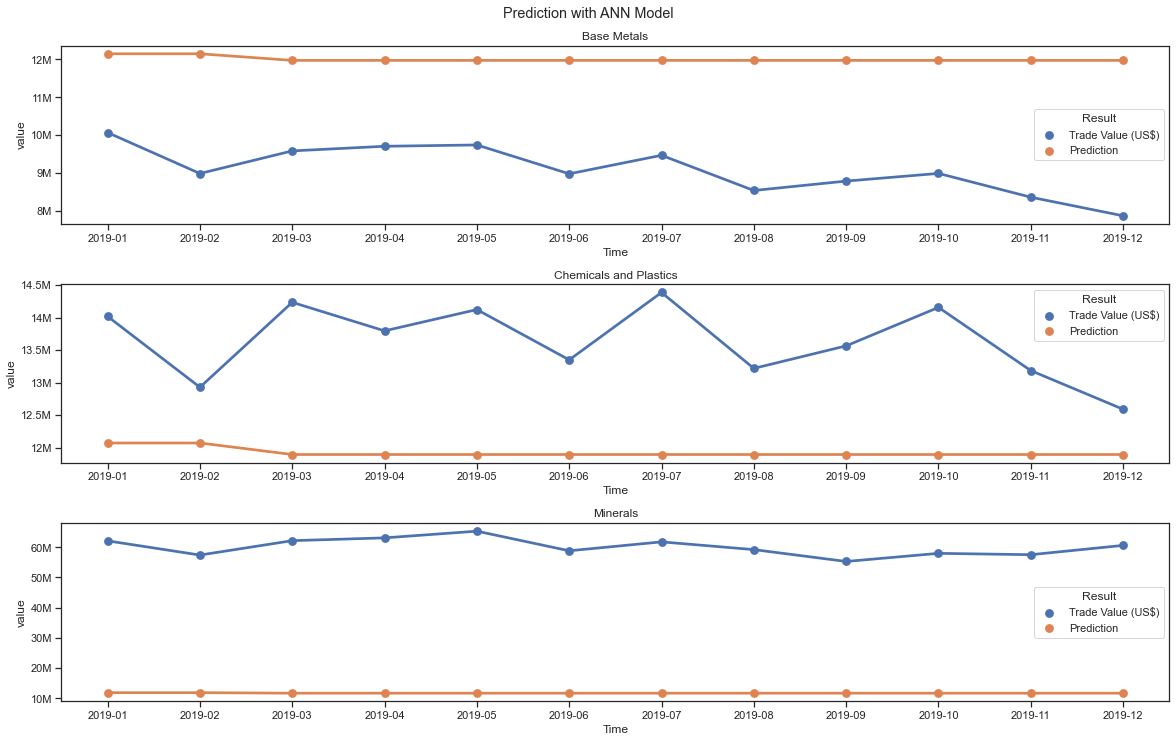

In [89]:
fig,axes= plt.subplots(nrows=3, figsize=(1,1))
fig.set_size_inches(16.5, 10.5)
grouped_predictions = needed_value.groupby('Product')
sns.set(style="ticks")
for i, (g,ax) in enumerate(zip(grouped_predictions.groups, axes.flatten())):
    product_data = grouped_predictions.get_group(g)
    p = product_data.melt(value_vars=[output_column, 'Prediction'], var_name="Result", ignore_index=False)
    ax = sns.pointplot(x=p.index, y=p.value, data=p, hue ="Result", ax=ax, linestyles=["-", "-", ":"]);
    #ax.set_yticks(np.arange(p.value.min(), p.value.max(), 2000000))
    ax.set_title(g)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
fig.suptitle('Prediction with ANN Model');
fig.tight_layout();

In [91]:
needed_value.describe()

,Trade Value (US$),loss,Prediction
count,3.600000e+01,3.600000e+01,3.600000e+01
mean,2.760972e+07,2.048427e+07,1.188460e+07
std,2.344240e+07,2.049600e+07,1.336581e+05
min,7.872280e+06,5.114271e+06,1.169967e+07
25%,9.676043e+06,5.400902e+06,1.169967e+07
50%,1.368115e+07,7.187466e+06,1.189419e+07
75%,5.763949e+07,4.663885e+07,1.197180e+07
max,6.531281e+07,5.412649e+07,1.214583e+07


## Other models: FB Prophet, VAR, LSTM

In [8]:
reporterencoder = LabelEncoder()
df = main_data.copy()
df["Reporter"] = reporterencoder.fit_transform(df['Reporter'])
reporter_mapping = dict(zip(reporterencoder.classes_, reporterencoder.transform(reporterencoder.classes_)))
products_mapping = {'1': 'Fruits and Vegatables', '2': 'Meat and Seafood',  '3': 'Grains and Cereals', '4':'Beverages', '5':'Dairy', '6': 'Minerals', '7': 'Base Metals', '8': 'Chemicals and Plastics', '9': 'Guns'}




## Train with fb prophet
* FB Prophet gives the best accuracy from the models tested so far
* This model is typically used for univariant time series data
* We have 

In [89]:
data = df.copy()
columns_to_remove = {'Commodity Code', 'Gdp_per_capita', 'Population'}
output_col = output_column
fb = Facebook()
predictions, final, rsme, mae = fb.predict(data, columns_to_remove, output_col, periods=12, freq='M')


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



In [71]:
rsme

3335791.1056033676

In [72]:
mae

3120846.954094121

In [70]:
predictions

,Time,group,y_true,y_pred
0,2019-01,6,7.040294e+07,6.371395e+07
1,2019-02,6,6.486806e+07,5.916344e+07
2,2019-03,6,7.066423e+07,6.367241e+07
3,2019-04,6,7.159249e+07,6.142269e+07
4,2019-05,6,7.499453e+07,6.152363e+07
5,2019-06,6,6.748443e+07,5.972384e+07
6,2019-07,6,6.990270e+07,6.169537e+07
7,2019-08,6,6.784476e+07,6.169157e+07
8,2019-09,6,6.222524e+07,5.888836e+07
9,2019-10,6,6.474267e+07,5.938901e+07


In [26]:
final.tail()

,yhat_6,yhat_7,yhat_8
ds,,,
2019-07-31,6.169157e+07,1.092034e+07,1.521511e+07
2019-08-31,5.888836e+07,1.190435e+07,1.586423e+07
2019-09-30,5.938901e+07,1.201815e+07,1.609163e+07
2019-10-31,5.860092e+07,1.158732e+07,1.554584e+07
2019-11-30,5.981840e+07,1.070520e+07,1.476445e+07


In [90]:
predictions['Product'] = ''
reporter_key_list = list(reporter_mapping.keys())
reporter_val_list = list(reporter_mapping.values())
for index, row in predictions.iterrows():
    group = row.group
    predictions.loc[index, 'Product'] = products_mapping[str(group)]
predictions = predictions.drop(columns={'group'}).rename(columns={'y_true':'Real Value', 'y_pred':'Predicted'})
predictions = predictions.set_index('Time')



In [13]:
sns.set_theme()

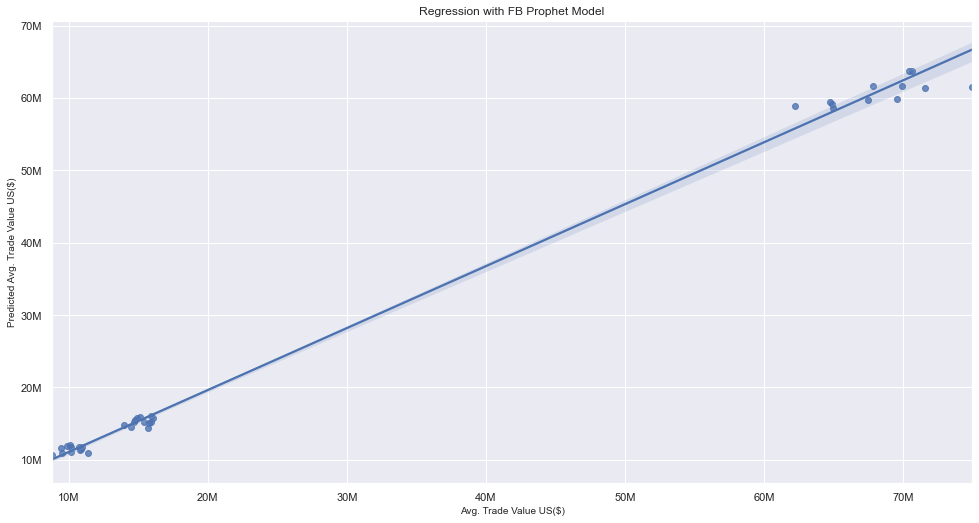

In [15]:
true_value = predictions['Real Value']
predicted_value =predictions['Predicted']
fig, ax = plt.subplots(figsize=(1,1))
fig.set_size_inches(16.5, 8.5)
g = sns.regplot(x=true_value, y=predicted_value, data=predictions, robust=True, ax=ax)
g.set_title('Regression with FB Prophet Model', size=12);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.xaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.set_ylabel(ylabel='Predicted Avg. Trade Value US($)', size=10);
g.set_xlabel(xlabel='Avg. Trade Value US($)', size=10);

In [95]:
adi.head(50)

,Type,Category,Value
Date,,,
2019-01-01,Predicted,Minerals,6.681973e+07
2019-02-01,Predicted,Minerals,6.559561e+07
2019-03-01,Predicted,Minerals,6.871490e+07
2019-04-01,Predicted,Minerals,6.920036e+07
2019-05-01,Predicted,Minerals,7.404305e+07
2019-06-01,Predicted,Minerals,7.226058e+07
2019-07-01,Predicted,Minerals,6.952628e+07
2019-08-01,Predicted,Minerals,6.958964e+07
2019-09-01,Predicted,Minerals,6.408487e+07


In [91]:
predictions

,Real Value,Predicted,Product
Time,,,
2019-01,7.040294e+07,6.371395e+07,Minerals
2019-02,6.486806e+07,5.916344e+07,Minerals
2019-03,7.066423e+07,6.367241e+07,Minerals
2019-04,7.159249e+07,6.142269e+07,Minerals
2019-05,7.499453e+07,6.152363e+07,Minerals
2019-06,6.748443e+07,5.972384e+07,Minerals
2019-07,6.990270e+07,6.169537e+07,Minerals
2019-08,6.784476e+07,6.169157e+07,Minerals
2019-09,6.222524e+07,5.888836e+07,Minerals


In [119]:
product_data = predictions.groupby(predictions.index).agg({"Predicted":"mean", "Real Value": "mean"}).reset_index().set_index('Time')

In [120]:
product_data.to_excel('Fb.xlsx')

In [93]:
adi = pd.read_csv('merged.csv',index_col='Date')

In [121]:
#adi = adi.reset_index()
adi = adi.pivot_table(index=['Date', 'Category'], columns='Type', values='Value')[['Predicted', 'Real']].reset_index()

In [123]:
adi = adi.groupby(["Date"]).agg({"Predicted":"mean", "Real":"mean"}).reset_index().set_index("Date")

In [125]:
product_data

,Predicted,Real Value
Time,,
2019-01,2.968108e+07,3.247639e+07
2019-02,2.826234e+07,2.984806e+07
2019-03,3.010832e+07,3.246484e+07
2019-04,2.935171e+07,3.263764e+07
2019-05,2.943967e+07,3.388882e+07
2019-06,2.906587e+07,3.084173e+07
2019-07,2.973825e+07,3.223288e+07
2019-08,2.927567e+07,3.068461e+07
2019-09,2.888565e+07,2.907142e+07


In [124]:
adi

,Predicted,Real
Date,,
2019-01-01,3.054731e+07,3.247639e+07
2019-02-01,3.032260e+07,2.984806e+07
2019-03-01,3.180405e+07,3.246484e+07
2019-04-01,3.181080e+07,3.263764e+07
2019-05-01,3.362934e+07,3.388882e+07
2019-06-01,3.261935e+07,3.084173e+07
2019-07-01,3.186061e+07,3.223288e+07
2019-08-01,3.148246e+07,3.068461e+07
2019-09-01,2.960669e+07,2.907142e+07


In [84]:
adi = adi[~(adi.Type=='Real')]

In [85]:
adi.to_excel('adi.xlsx')

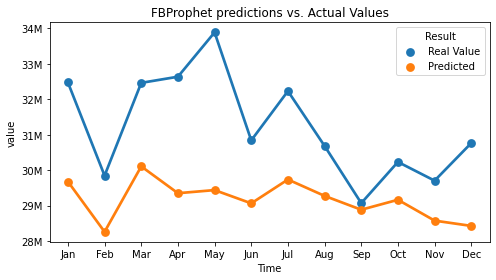

In [30]:
import matplotlib.dates as mdates
fig,ax= plt.subplots(figsize=(7,4))
#fig.set_size_inches(10.5, 5.5)
product_data = predictions.groupby(predictions.index).agg({"Predicted":"mean", "Real Value": "mean"}).reset_index().set_index('Time')
p = product_data.melt(value_vars=['Real Value', 'Predicted'], var_name="Result", ignore_index=False)
ax = sns.pointplot(ax=ax, x=p.index.strftime('%b'), y=p.value, data=p, hue ="Result");
ax.set_title("FBProphet predictions vs. Actual Values")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));

fig.tight_layout();

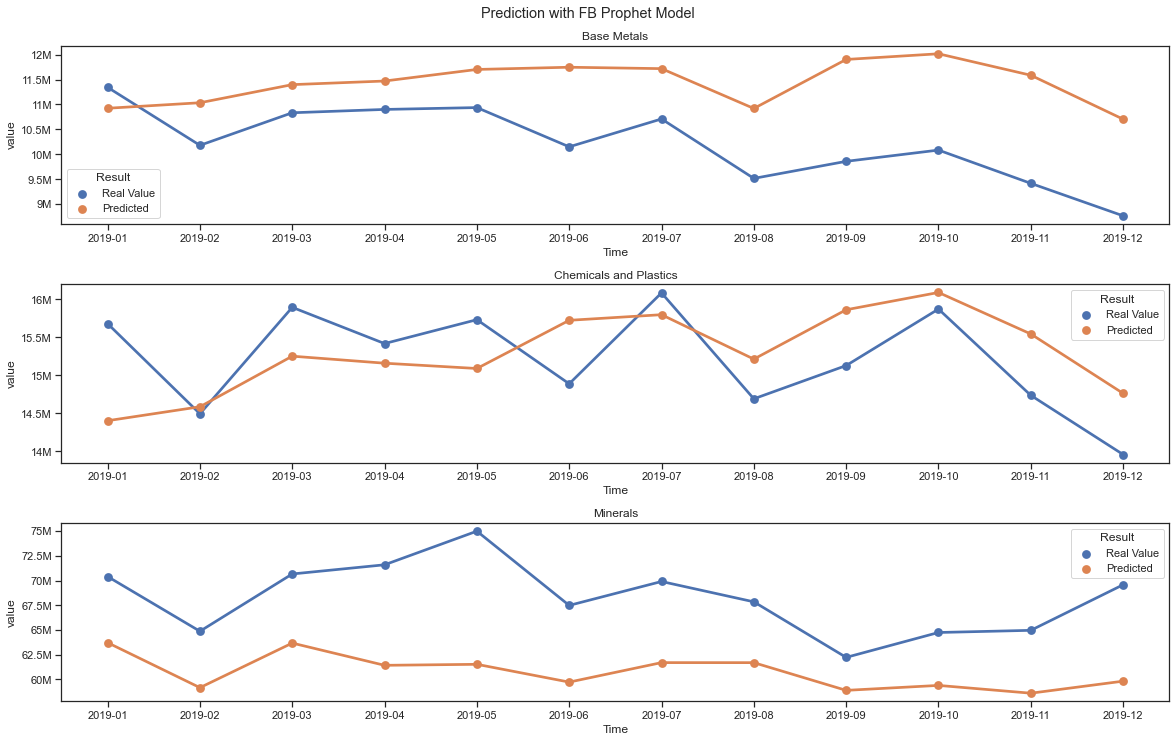

In [32]:
fig,axes= plt.subplots(nrows=3, figsize=(1,1))
fig.set_size_inches(16.5, 10.5)
grouped_predictions = predictions.groupby('Product')
sns.set(style="ticks")
for i, (g,ax) in enumerate(zip(grouped_predictions.groups, axes.flatten())):
    product_data = grouped_predictions.get_group(g)
    p = product_data.melt(value_vars=['Real Value', 'Predicted'], var_name="Result", ignore_index=False)
    ax = sns.pointplot(x=p.index, y=p.value, data=p, hue ="Result", ax=ax, linestyles=["-", "-", ":"]);
    ax.set_title(g)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
fig.suptitle('Prediction with FB Prophet Model');
fig.tight_layout();

#ax2 = sns.scatterplot(x=predictions.index.month, y=true_value, data=predictions, ax=ax1)

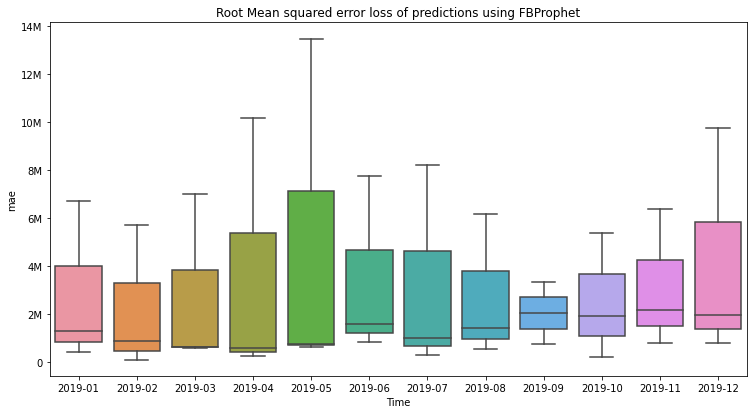

In [63]:
fig,ax= plt.subplots(figsize=(1,1))
fig.set_size_inches(12.5, 6.5)
title = "Root Mean squared error loss of predictions using FBProphet"
ax = sns.boxplot(y="mae", x=predictions.index, data=predictions, ax=ax);
ax.set_title(title)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
#plt.suptitle(f'(Reporter, Product): {test.group.values}')


In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rsme = np.sqrt(mean_squared_error(predictions['Real Value'], predictions.Predicted))
mae = mean_absolute_error(predictions['Real Value'], predictions.Predicted)

In [67]:
rsme


4659101.302367515

In [64]:
predictions.describe()

,Real Value,Predicted,mae,rsme
count,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01
mean,3.123763e+07,2.916518e+07,3.120847e+06,3.120847e+06
std,2.672121e+07,2.275011e+07,3.508485e+06,3.508485e+06
min,8.764902e+06,1.070520e+07,9.259018e+04,9.259018e+04
25%,1.088402e+07,1.174112e+07,6.423890e+05,6.423890e+05
50%,1.527509e+07,1.523447e+07,1.340413e+06,1.340413e+06
75%,6.489134e+07,5.921983e+07,5.816764e+06,5.816764e+06
max,7.499453e+07,6.371395e+07,1.347090e+07,1.347090e+07


## Train with vector autoregression

## Preprocessing

In [18]:

#remove constants
data = df.loc[:, (df != df.iloc[0]).any()]
var = VAR(data, output_column, {'Commodity Code'})


33756 3528


In [19]:
var.train_var = var.train_var.loc[:, (var.train_var != var.train_var.iloc[0]).any()]
var.test_var = var.test_var.loc[:, (var.test_var != var.test_var.iloc[0]).any()]

In [14]:
var.adf_test(var.train_var[output_column])

Test Statistic         -6.451940e+00
p-value                 1.515886e-08
# Lags                  3.700000e+01
# Observations          8.401000e+03
Critical Value (1%)    -3.431129e+00
Critical Value (5%)    -2.861884e+00
Critical Value (10%)   -2.566953e+00
dtype: float64
 Series is Stationary


In [15]:
var.show_lag_orders([6])


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       40.82       40.82   5.349e+17       40.82
1       39.73       39.74   1.792e+17       39.73
2       39.48       39.50   1.403e+17       39.49
3       39.45       39.48   1.365e+17       39.47
4       39.34       39.38   1.222e+17       39.36
5       39.30       39.35   1.170e+17       39.32
6      39.28*      39.33*  1.145e+17*      39.30*
-------------------------------------------------
Lag Order = 6
AIC :  39.27943361552548
BIC :  39.332103995757066
FPE :  1.1450944787671517e+17
HQIC:  39.298392602019675 



In the above output, the AIC drops to lowest at lag 26. So we pick lag 1

In [20]:
max_lag = 15
opt_lag = 1

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [21]:

grouped = var.train_var.groupby(['Category Code'])
train_results = var.train(max_lag, grouped)


Trade Value (US$) : 1.98
Population : 2.0
Trade Value (US$) : 1.98
Population : 2.02
Trade Value (US$) : 1.98
Population : 2.01


In [33]:
for key, value in train_results.items():
    fevd = value.fevd(5)
    print(f"Fevd estimation {key}\n{fevd.summary()}")

FEVD for Trade Value (US$)
     Trade Value (US$)  Population
0             1.000000    0.000000
1             0.999969    0.000031
2             0.999630    0.000370
3             0.996983    0.003017
4             0.964991    0.035009

FEVD for Population
     Trade Value (US$)  Population
0             0.215507    0.784493
1             0.238868    0.761132
2             0.252652    0.747348
3             0.255592    0.744408
4             0.255182    0.744818


Fevd estimation 6
None
FEVD for Trade Value (US$)
     Trade Value (US$)  Population
0             1.000000    0.000000
1             0.993846    0.006154
2             0.988604    0.011396
3             0.987122    0.012878
4             0.986941    0.013059

FEVD for Population
     Trade Value (US$)  Population
0             0.158151    0.841849
1             0.159043    0.840957
2             0.157615    0.842385
3             0.157071    0.842929
4             0.164699    0.835301


Fevd estimation 7
None
FEVD for Trade

In [34]:
# forecasting
test_grouped = var.test_var.groupby(['Category Code'])
forecasts = var.forecast(12, grouped, test_grouped, train_results, products_mapping)


In [35]:
test_values = var.test_var.copy()
test_values = test_values.reset_index()
test_values['Product'] = ''
for index, row in test_values.iterrows():
    test_values.loc[index, 'Product'] = products_mapping[str(row['Category Code'])]
test_values = test_values.drop(columns={'Reporter', 'Category Code'})

In [36]:
from sklearn.metrics import mean_squared_error
predictions = forecasts.copy().reset_index()
predictions['Real Value'] = test_values.reset_index()[output_column]
predictions = predictions.rename(columns={'index':'Time', 'Trade Value (US$)': 'Predicted'})

predictions['mae']=predictions.apply(lambda row: mean_squared_error([row['Real Value']], [row['Predicted']]), axis=1)
predictions = predictions.drop(columns={'Population'})
predictions = predictions.set_index('Time')

In [37]:
predictions['rsme'] = np.sqrt(predictions['mae'])
predictions.head()

,Predicted,Product,Real Value,mae,rsme
Time,,,,,
2019-01,8.019082e+07,Minerals,8.679441e+06,5.113878e+15,7.151138e+07
2019-02,3.507649e+07,Minerals,1.755479e+06,1.110290e+15,3.332101e+07
2019-03,6.460328e+07,Minerals,3.192190e+06,3.771322e+15,6.141109e+07
2019-04,4.749384e+07,Minerals,4.134887e+07,3.776062e+13,6.144967e+06
2019-05,8.544117e+07,Minerals,4.992466e+06,6.471994e+15,8.044871e+07


In [38]:
sns.set_theme()

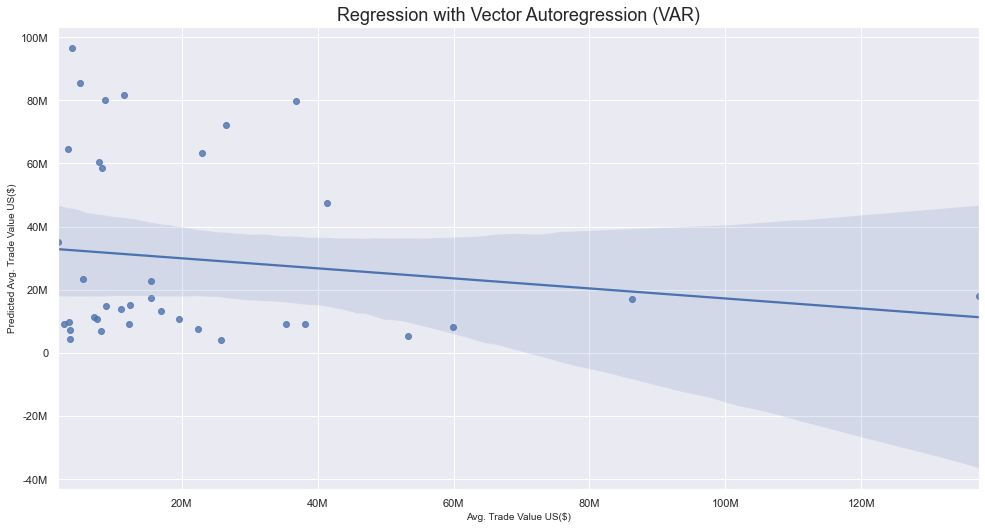

In [39]:
true_value = predictions['Real Value']
predicted_value =predictions['Predicted']
fig, ax = plt.subplots(figsize=(1,1))
fig.set_size_inches(16.5, 8.5)
g = sns.regplot(x=true_value, y=predicted_value, data=predictions, robust=True, ax=ax)
g.set_title('Regression with Vector Autoregression (VAR)', size=18);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.xaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.set_ylabel(ylabel='Predicted Avg. Trade Value US($)', size=10);
g.set_xlabel(xlabel='Avg. Trade Value US($)', size=10);

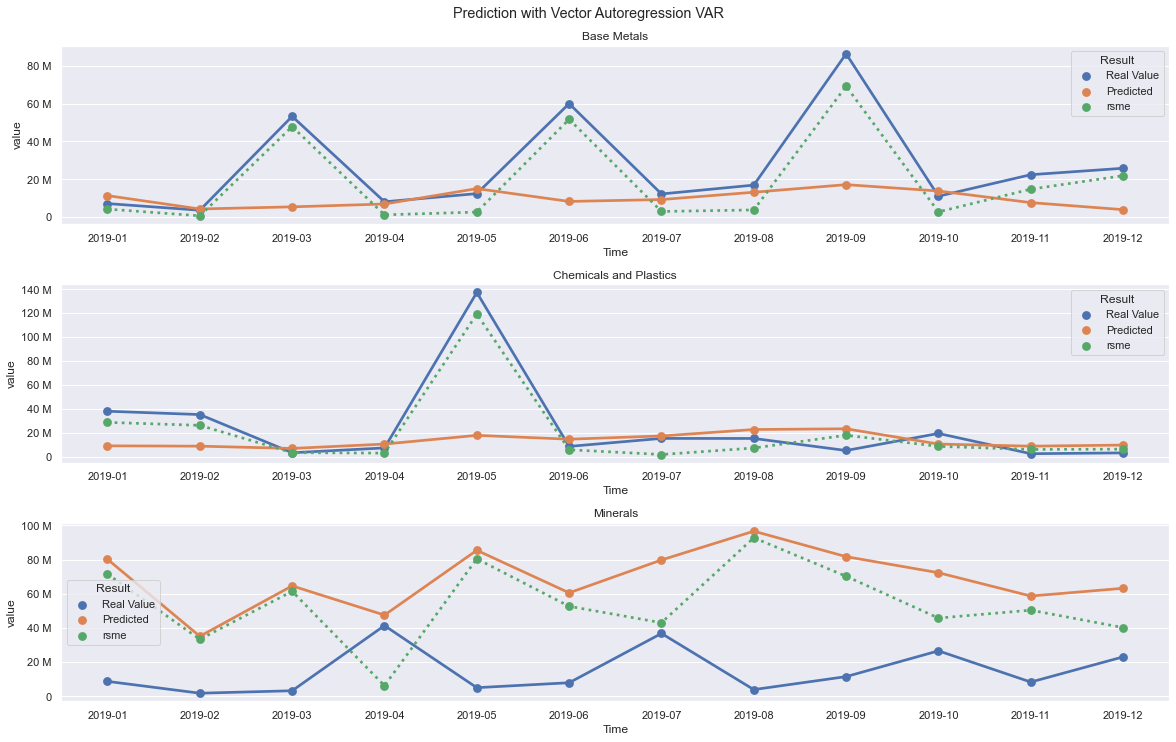

In [40]:
fig,axes= plt.subplots(nrows=3, figsize=(1,1))
fig.set_size_inches(16.5, 10.5)
grouped_predictions = predictions.groupby('Product')
sns.set_theme()
for i, (g,ax) in enumerate(zip(grouped_predictions.groups, axes.flatten())):
    product_data = grouped_predictions.get_group(g)
    p = product_data.melt(value_vars=['Real Value', 'Predicted', 'rsme'], var_name="Result", ignore_index=False)
    ax = sns.pointplot(x=p.index, y=p.value, data=p, hue ="Result", ax=ax, linestyles=["-", "-", ":"]);
    ax.set_title(g)
    ax.yaxis.set_major_formatter(ticker.EngFormatter());
fig.suptitle('Prediction with Vector Autoregression VAR');
fig.tight_layout();

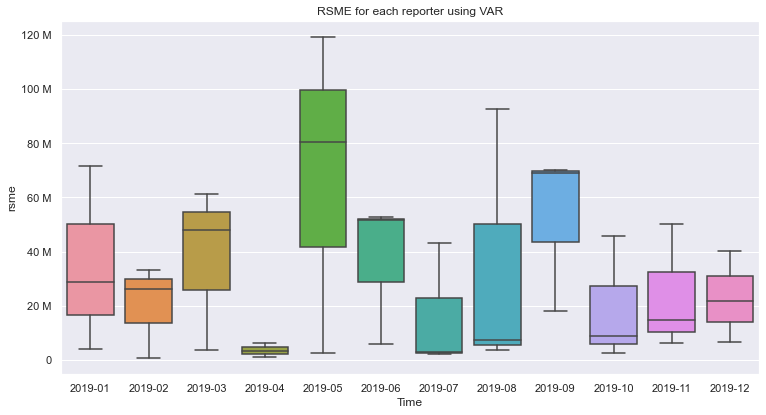

In [41]:
#Box plot
title = 'RSME for each reporter using VAR'
fig,ax= plt.subplots(figsize=(1,1))
fig.set_size_inches(12.5, 6.5)
ax = sns.boxplot(y="rsme", x=predictions.index, data=predictions, ax=ax);
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(title);

In [42]:
predictions.describe()

,Predicted,Real Value,mae,rsme
count,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01
mean,3.067786e+07,2.193314e+07,1.882335e+15,3.077572e+07
std,2.932953e+07,2.718152e+07,3.013175e+15,3.101467e+07
min,3.923760e+06,1.755479e+06,4.403029e+11,6.635532e+05
25%,9.198640e+06,6.697244e+06,1.683749e+13,4.099020e+06
50%,1.492969e+07,1.184227e+07,4.036031e+14,2.000221e+07
75%,5.912224e+07,2.598934e+07,2.571169e+15,5.070340e+07
max,9.663483e+07,1.372513e+08,1.421368e+16,1.192211e+08


## LSTM

In [14]:
data = main_data.groupby(['Time','Reporter', 'Category Code','Commodity Code']).agg({output_column:'mean', 'Population':'last', 'Gdp_per_capita':'last'}).reset_index().set_index('Time')
dum_df = pd.get_dummies(data, columns=["Reporter", "Commodity Code", "Category Code"])
data = dum_df.copy()
train = data[data.index<"2019"]
test = data[data.index >= "2019"]
input_columns = ['Gdp_per_capita', 'Population']
lstm = LSTM(data, train, test, input_columns, output_column)
lstm.scale()

* Train with LSTM
* reshape to [samples, time_steps, n_features]

In [16]:

#results = pd.DataFrame()
#batches = [12, 24, 32, 64, 80]
#time_steps = [12, 50, 60, 70, 80]
#layers = [1, 1, 2, 2, 2]
#neurons = [128, 128, 256, 312, 500]
#train using past 36 months data to predict next twelve months
hparams = {"time_steps":36, "neurons":128, "dropout":0.2, "layers":1, "epochs":30, "batch":12, "lr":0.001}
model, hist_df = lstm.train(hparams, 'lstmmodels')
    


Epoch 1/30
4390/4390 [==============================] - 1237s 278ms/step - loss: 145.9403 - val_loss: 1.6568
Epoch 2/30
4390/4390 [==============================] - 415s 94ms/step - loss: 2.5052 - val_loss: 1.3415
Epoch 3/30
4390/4390 [==============================] - 166s 38ms/step - loss: 1.8636 - val_loss: 0.8190
Epoch 4/30
4390/4390 [==============================] - 161s 37ms/step - loss: 1.4681 - val_loss: 0.6917
Epoch 5/30
4390/4390 [==============================] - 165s 38ms/step - loss: 1.2179 - val_loss: 0.6733
Epoch 6/30
4390/4390 [==============================] - 162s 37ms/step - loss: 1.1768 - val_loss: 0.6106
Epoch 7/30
4390/4390 [==============================] - 159s 36ms/step - loss: 1.0952 - val_loss: 0.6435
Epoch 8/30
4390/4390 [==============================] - 159s 36ms/step - loss: 0.9824 - val_loss: 0.7515
Epoch 9/30
4390/4390 [==============================] - 144s 33ms/step - loss: 0.9287 - val_loss: 0.6520
Epoch 10/30
4390/4390 [============================

FileNotFoundError: [Errno 2] No such file or directory: 'lstmmodels/history_128.csv'

In [ ]:
df_results = pd.DataFrame()
filenames = ['history_0.csv', 'history_2.csv',
	'history_3.csv','history_4','history_5.csv']
for name in filenames:
	df_results[name[0:-9]] = read_csv(name, header=0)
# describe all results
print(df_results.describe())
# box and whisker plot
df_results.boxplot()
plt.show()

* Using one layer bi-directional lstm with a drop out layer

# Predict only after satification with train result
* Now we predict for 2019

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = tradeval_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = tradeval_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = tradeval_transformer.inverse_transform(y_pred)

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Trade value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Trade value')
plt.xlabel('Time Step')
plt.legend()
plt.show();